## Load Dataset 

In [ ]:
import os
import gc
import copy

import numpy as np
import pandas as pd

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [2]:
import os

classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
train_path = 'dataset/train/'
test_path = 'dataset/test/0/'

print("[ 학습 데이터셋 ]")
for i in range(7):
    print(f'클래스 {i}의 개수: {len(os.listdir(train_path + classes[i]))}')

print("[ 데스트 데이터셋 ]")
print(f'클래스 {i}의 개수: {len(os.listdir(test_path))}')

[ 학습 데이터셋 ]
클래스 0의 개수: 329
클래스 1의 개수: 205
클래스 2의 개수: 235
클래스 3의 개수: 134
클래스 4의 개수: 151
클래스 5의 개수: 245
클래스 6의 개수: 399
[ 데스트 데이터셋 ]
클래스 6의 개수: 350


In [3]:
import torch
from torchvision import datasets, transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transforms_test = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train)
test_files = os.listdir(test_path)
test_files = sorted(test_files)
test_files = list(map(lambda x: '/'.join([test_path, x],), test_files))
test_dataset = datasets.ImageFolder(test_path[:-2], transforms_train)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataloader))

class_names = train_dataset.classes
print('Class names:', class_names)

Training dataset size: 1698
Test dataset size: 11
Class names: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [4]:
from torch.utils.data import Dataset
class ArtDataset(Dataset):
    def __init__(self, file, transform=None):
        self.file = file.copy()
        self.transform = transform
    def __getitiem__(self, idx):
        data = self.df.iloc[idx]
        img_path = data['img_path']
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = data['label']
        return img, label
    def __len__(self):
        return len(self.df)
    

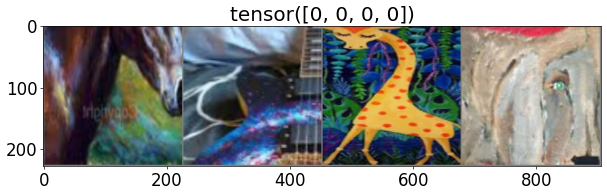

In [5]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 이미지 정규화(normalization) 해제하기
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 학습 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(test_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=classes[:4])
#imshow(out, title=[class_names[x] for x in classes[:4]])

In [6]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print(f'[Total Train epoch: {epoch}]')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)

In [7]:
# code with Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000)
        )
    def forward(self, x):
        #print(x.shape)
        x = self.features(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [21]:
import time
import torch.optim as optim


net = AlexNet()
net = net.to(device)

epoch = 50
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    #val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    #val_result.append((val_acc, val_loss))

[Total Train epoch: 0]
Train accuarcy: 17.137809187279153
Train average loss: 0.2170114256046686
Model saved! (time elapsed: 5.655981540679932)
[Total Train epoch: 1]
Train accuarcy: 23.498233215547703
Train average loss: 0.2083462904985156
Model saved! (time elapsed: 10.914563179016113)
[Total Train epoch: 2]
Train accuarcy: 20.906949352179033
Train average loss: 0.121010874480325
Model saved! (time elapsed: 15.964679956436157)
[Total Train epoch: 3]
Train accuarcy: 19.67020023557126
Train average loss: 0.0629513790947248
Model saved! (time elapsed: 21.041622161865234)
[Total Train epoch: 4]
Train accuarcy: 18.72791519434629
Train average loss: 0.06387015640103774
Model saved! (time elapsed: 35.60760188102722)
[Total Train epoch: 5]
Train accuarcy: 20.49469964664311
Train average loss: 0.06364507564245882
Model saved! (time elapsed: 41.06161642074585)
[Total Train epoch: 6]
Train accuarcy: 19.316843345111895
Train average loss: 0.06265284020993397
Model saved! (time elapsed: 46.280505

In [19]:
iterator = iter(test_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, targets = next(iterator)
inputs, targets = inputs.to(device), targets.to(device)
outputs = net(inputs)
print(outputs)
_, predicted = outputs.max(1)
print(predicted)

tensor([[ 8.2863e+00,  8.2482e+00,  8.2166e+00,  ..., -1.5814e-01,
         -4.8209e-02, -2.1848e-02],
        [ 9.6959e+00,  9.0491e+00,  7.8783e+00,  ..., -1.6826e-01,
         -3.0387e-01, -9.0688e-02],
        [ 1.0682e+01,  1.1154e+01,  1.0856e+01,  ..., -2.3196e-01,
         -1.2262e-02,  7.4654e-02],
        ...,
        [ 9.5828e+00,  8.6812e+00,  7.8459e+00,  ...,  2.7773e-03,
         -2.1104e-01,  4.8508e-03],
        [ 9.6294e+00,  8.6516e+00,  8.4019e+00,  ...,  3.5411e-02,
         -2.0610e-01, -2.1024e-01],
        [ 9.8975e+00,  1.0329e+01,  1.0093e+01,  ..., -8.3299e-02,
         -7.0607e-02,  1.9050e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([6, 6, 1, 6, 6, 0, 1, 1, 6, 5, 6, 6, 1, 6, 6, 0, 1, 6, 2, 6, 6, 6, 6, 1,
        0, 6, 1, 1, 6, 6, 6, 1], device='cuda:0')


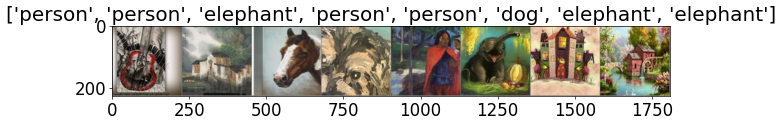

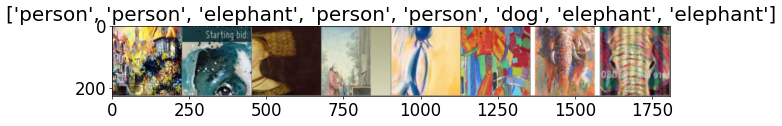

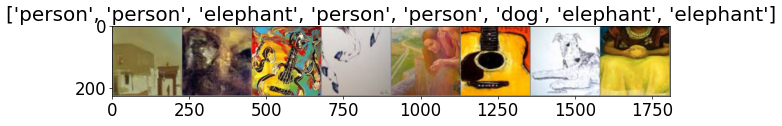

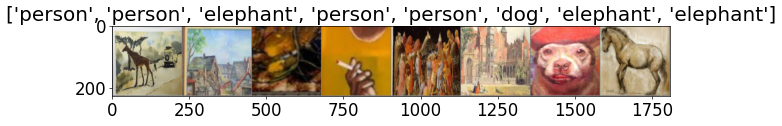

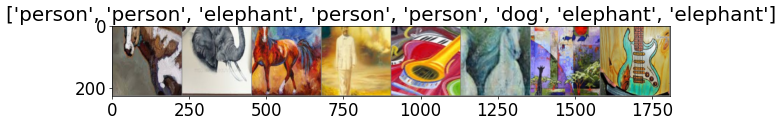

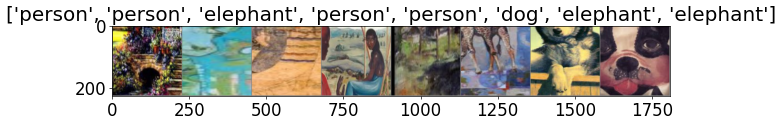

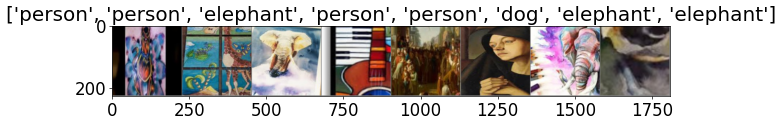

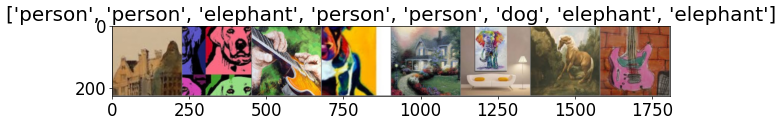

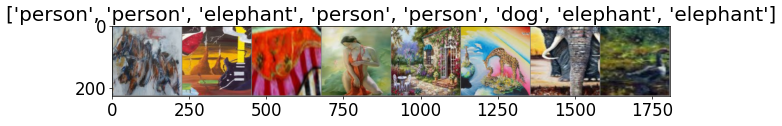

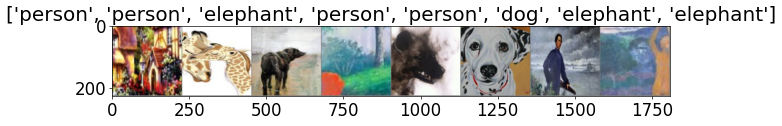

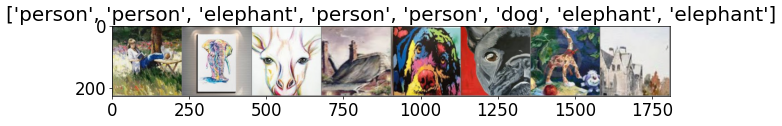

In [23]:
net.eval()
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
for batch_idx, (inputs, targets) in enumerate(test_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    
    inputs = inputs.to('cpu')
    out = torchvision.utils.make_grid(inputs[:8])
    imshow(out, title=[classes[x] for x in predicted[:8]])
    